In [1]:
import _mypackage

import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
%matplotlib inline

In [2]:
import my_plotting as mp

In [3]:
import sys
sys.path.append('./SAMBA')

In [4]:
from SAMBA.samba import models
from SAMBA.samba import mixing
from Taweret.mix.linear import LinearMixerLocal
from Taweret.core.base_model import BaseModel
from bilby.core import prior as bilby_prior

Samba GitHub repository available at: https://github.com/asemposki/SAMBA  
I presonally clone it into the same directory as this notebook.

In [5]:
class loworder(BaseModel):
    """
    A wrapper for SAMBA low order expansion function

    """

    def __init__(self, order, error_model='informative'):
        """
        Parameters
        ----------
        order : int
            Truncation order of expansion
        error_model : str
            Error calculation method. Either 'informative' or 'uninformative'
        
        Raises
        ------
        TypeError
            If the order is not an integer
        """

        if isinstance(order, int):
            self.order = order
        else:
            raise TypeError(f"order has to be an integer number: {order}")

        self.error_model = error_model
        self.prior = None

    def evaluate(self, input_values : np.array) -> np.array:
        """
        Evaluate the mean and error for given input values

        Parameters
        ----------
        input_values : numpy 1darray
            coupling strength (g) values
        
        Returns:
        --------
        mean : numpy 1darray
            The mean of the model
        np.sqrt(var) : numpy 1darray
            The truncation error of the model
        """

        order = self.order
        M = models.Models(order, order)
        mean = M.low_g(input_values)
        U = models.Uncertainties(self.error_model)
        var = U.variance_low(input_values, order)

        return mean, np.sqrt(var)

    def log_likelihood_elementwise(self, x_exp, y_exp, y_err):
        predictions, model_err = self.evaluate(x_exp)
        sigma = np.sqrt(np.square(y_err) + np.square(model_err))
        diff = -0.5* np.square((predictions.flatten() - y_exp)/ sigma) \
            - 0.5 * np.log(2*np.pi)- np.log(sigma)
        return diff

    def set_prior(self):
        '''
        Set the prior on model parameters.
        Not needed for this model. 
        '''
        return None


class highorder(BaseModel):
    """
    A wrapper for SAMBA high order expansion function

    """   

    def __init__(self, order, error_model='informative'):
        """
        Parameters
        ----------
        order : int
            Truncation order of expansion
        error_model : str
            Error calculation method. Either 'informative' or 'uninformative'
        
        Raises
        ------
        TypeError
            If the order is not an integer
        """

        if isinstance(order, int):
            self.order = order
        else:
            raise TypeError(f"order has to be an integer number: {order}")

        self.error_model = error_model
        self.prior = None
        
    def evaluate(self, input_values : np.array) -> np.array:
        """
        Evaluate the mean and error for given input values

        Parameters
        ----------
        input_values : numpy 1darray
            coupling strength (g) values

        Returns:
        --------
        mean : numpy 1darray
            The mean of the model
        np.sqrt(var) : numpy 1darray
            The truncation error of the model
        """

        order = self.order
        M = models.Models(order, order)
        mean = M.high_g(input_values)
        U = models.Uncertainties(self.error_model)
        var = U.variance_high(input_values, order)

        return mean, np.sqrt(var)

    def log_likelihood_elementwise(self, x_exp, y_exp, y_err):
        predictions, model_err = self.evaluate(x_exp)
        sigma = np.sqrt(np.square(y_err) + np.square(model_err))
        diff = -0.5* np.square((predictions.flatten() - y_exp)/ sigma) \
            - 0.5 * np.log(2*np.pi)- np.log(sigma)
        return diff

    def set_prior(self):
        '''
        Set the prior on the model parameters.
        Not needed for this model. 
        '''
        return None
    

class true_model(BaseModel):
    """
    A wrapper for SAMBA  true function
    """

    def evaluate(self, input_values : np.array) -> np.array:
        """
        Evaluate the mean and error for given input values
        Parameters
        ----------
        input_values : numpy 1darray
            coupling strength (g) values
        """

        order = 1
        M = models.Models(order, order)
        mean = M.true_model(input_values)
        var = np.zeros(shape=mean.shape)
        return mean, np.sqrt(var)

    def log_likelihood_elementwise(self, x_exp, y_exp, y_err):
        return log_likelihood_elementwise_utils(self, x_exp, y_exp, y_err)

    def set_prior(self):
        '''
        Set the prior on any model parameters.
        Not needed for this model. 
        '''
        return None 


class exp_data(BaseModel):    # --> check that this model is set up correctly
    """
    A wrapper for SAMBA data function

    """

    def evaluate(self, input_values : np.array, error = 0.01) -> np.array:
        """
        Evaluate the mean and error for given input values

        Parameters
        ----------
        input_values : numpy 1darray
            coupling strength (g) values
        error : float
            defines the relative error as a fraction between (0,1)
        """

        order = 1
        M = mixing.LMM(order, order, error_model='informative')
        mean, sigma = M.add_data(input_values, input_values, error=error, plot=False)
        
        return mean, sigma

    def log_likelihood_elementwise(self):
        return None

    def set_prior(self):
        '''
        Set the prior on any model parameters.
        Not needed for this model. 
        '''
        return None 

In [6]:
m1 = loworder(2, 'uninformative')
m2 = highorder(2, 'uninformative')
truth = true_model()
exp = exp_data()

In [7]:
g = np.linspace(0.1, 0.6, 10)
plot_g = np.linspace(0.01,1,100)
m1_prediction = m1.evaluate(plot_g)
m2_prediction = m2.evaluate(plot_g)
true_output = truth.evaluate(plot_g)
exp_data= exp.evaluate(g, error = 0.01)

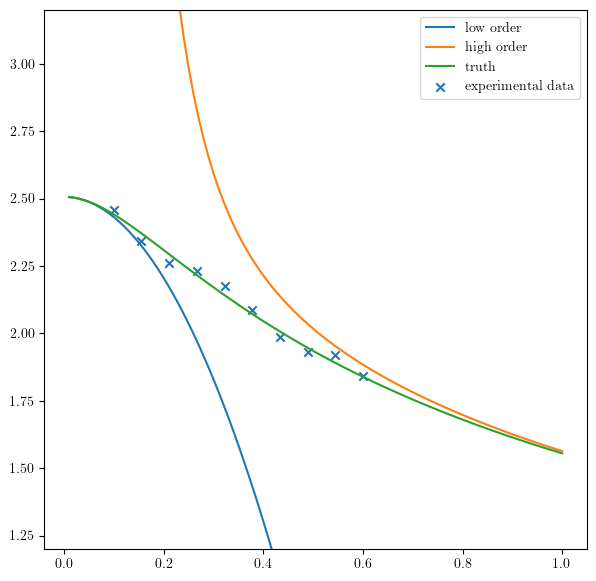

In [8]:
fig, ax_f = plt.subplots(figsize=(7, 7))
ax_f.plot(plot_g, m1_prediction[0].flatten(), label='low order')
ax_f.plot(plot_g, m2_prediction[0].flatten(), label='high order')
ax_f.plot(plot_g, true_output[0], label='truth')
ax_f.scatter(g, exp_data[0], marker='x', label='experimental data')
ax_f.set_ylim(1.2,3.2)
ax_f.legend()

In [9]:
my_models = {'low_order':m1,'high_order':m2}
mix_model = LinearMixerLocal(models=my_models) 
mix_model.set_prior(
    example_local_variable=np.array([0]),
    local_variables_ranges=np.array([[-20, 20]]),
    deterministic_priors=True,
    polynomial_order=1
)

In [10]:
exp_data

(array([2.45848483, 2.34247758, 2.26225038, 2.23180247, 2.17411167,
        2.08729452, 1.98783233, 1.93101806, 1.92143829, 1.84144758]),
 array([0.02458485, 0.02342478, 0.0226225 , 0.02231802, 0.02174112,
        0.02087295, 0.01987832, 0.01931018, 0.01921438, 0.01841448]))

In [11]:
posterior = mix_model.train(
    y_exp=exp_data[0],
    y_err=exp_data[1],
    local_variables=g,
    outdir='./plots',
)

18:29 bilby INFO    : Running for label 'label', output will be saved to './plots'
18:29 bilby INFO    : Analysis priors:
18:29 bilby INFO    : mu_(1, 0)=Uniform(minimum=-20, maximum=20, name='mu_(1, 0)', latex_label='mu_(1, 0)', unit=None, boundary=None)
18:29 bilby INFO    : sigma_(1, 0)=Uniform(minimum=-20, maximum=20, name='sigma_(1, 0)', latex_label='sigma_(1, 0)', unit=None, boundary=None)
18:29 bilby INFO    : Analysis likelihood class: <class 'Taweret.mix.linear.LinearMixerLocal.MixLikelihood'>
18:29 bilby INFO    : Analysis likelihood noise evidence: nan
18:29 bilby INFO    : Single likelihood evaluation took 1.726e-03 s
18:29 bilby WARNING : Supplied argument 'printdt' not an argument of 'Ptemcee', removing.
18:29 bilby INFO    : Using sampler Ptemcee with kwargs {'ntemps': 10, 'nwalkers': 40, 'Tmax': 100, 'betas': None, 'a': 2.0, 'adaptation_lag': 10000, 'adaptation_time': 100, 'random': None, 'adapt': False, 'swap_ratios': False}
18:29 bilby INFO    : Using convergence inpu

True


18:29 bilby INFO    : Generating pos0 samples
18:29 bilby INFO    : Starting to sample


1|0:00:01|nc:2.0e+03|a0:0.00-1.00|swp:0.46-0.93|n:nan<4000|t!nan(+nan,+nan)|q:inf|0.50ms/ev
2|0:00:02|nc:4.0e+03|a0:0.20-0.90|swp:0.48-0.93|n:nan<4000|t!nan(+nan,+nan)|q:inf|0.51ms/ev
3|0:00:03|nc:6.0e+03|a0:0.40-0.87|swp:0.51-0.93|n:nan<4000|t!nan(+nan,+nan)|q:inf|0.51ms/ev
4|0:00:04|nc:8.0e+03|a0:0.40-0.90|swp:0.57-0.93|n:nan<4000|t!nan(+nan,+nan)|q:inf|0.51ms/ev
5|0:00:05|nc:1.0e+04|a0:0.32-0.84|swp:0.59-0.93|n:nan<4000|t!nan(+nan,+nan)|q:inf|0.51ms/ev
6|0:00:06|nc:1.2e+04|a0:0.40-0.83|swp:0.61-0.93|n:nan<4000|t!nan(+nan,+nan)|q:inf|0.51ms/ev
7|0:00:07|nc:1.4e+04|a0:0.49-0.86|swp:0.63-0.94|n:nan<4000|t!nan(+nan,+nan)|q:inf|0.51ms/ev
8|0:00:08|nc:1.6e+04|a0:0.50-0.85|swp:0.64-0.94|n:nan<4000|t!nan(+nan,+nan)|q:inf|0.51ms/ev
9|0:00:09|nc:1.8e+04|a0:0.51-0.82|swp:0.66-0.94|n:nan<4000|t!nan(+nan,+nan)|q:inf|0.51ms/ev
10|0:00:10|nc:2.0e+04|a0:0.50-0.80|swp:0.67-0.94|n:nan<4000|t!nan(+nan,+nan)|q:inf|0.51ms/ev
11|0:00:11|nc:2.2e+04|a0:0.47-0.76|swp:0.67-0.94|n:nan<4000|t!nan(+nan,+nan)|q:

18:31 bilby INFO    : Writing checkpoint and diagnostics
18:31 bilby INFO    : Finished writing checkpoint


112|0:01:55|nc:2.2e+05|a0:0.61-0.69|swp:0.68-0.94|n:nan<4000|t!nan(+nan,+nan)|q:inf|0.62ms/ev
113|0:01:56|nc:2.3e+05|a0:0.61-0.69|swp:0.68-0.94|n:nan<4000|t!nan(+nan,+nan)|q:inf|0.62ms/ev
114|0:01:57|nc:2.3e+05|a0:0.61-0.69|swp:0.68-0.94|n:nan<4000|t!nan(+nan,+nan)|q:inf|0.64ms/ev
115|0:01:58|nc:2.3e+05|a0:0.61-0.69|swp:0.68-0.94|n:nan<4000|t!nan(+nan,+nan)|q:inf|0.51ms/ev
116|0:01:59|nc:2.3e+05|a0:0.61-0.69|swp:0.68-0.94|n:nan<4000|t!nan(+nan,+nan)|q:inf|0.50ms/ev
117|0:02:00|nc:2.3e+05|a0:0.60-0.69|swp:0.68-0.94|n:nan<4000|t!nan(+nan,+nan)|q:inf|0.49ms/ev
118|0:02:01|nc:2.4e+05|a0:0.60-0.69|swp:0.68-0.94|n:nan<4000|t!nan(+nan,+nan)|q:inf|0.50ms/ev
119|0:02:02|nc:2.4e+05|a0:0.60-0.69|swp:0.68-0.94|n:nan<4000|t!nan(+nan,+nan)|q:inf|0.51ms/ev
120|0:02:03|nc:2.4e+05|a0:0.60-0.69|swp:0.68-0.94|n:nan<4000|t!nan(+nan,+nan)|q:inf|0.51ms/ev
121|0:02:04|nc:2.4e+05|a0:0.60-0.69|swp:0.68-0.94|n:nan<4000|t!nan(+nan,+nan)|q:inf|0.50ms/ev
122|0:02:05|nc:2.4e+05|a0:0.61-0.70|swp:0.68-0.94|n:nan<4000

18:34 bilby INFO    : Finished sampling
18:34 bilby INFO    : Writing checkpoint and diagnostics
18:34 bilby INFO    : Finished writing checkpoint
18:34 bilby INFO    : Sampling time: 0:04:44.403211
18:34 bilby INFO    : Summary of results:
nsamples: 4040
ln_noise_evidence:    nan
ln_evidence: -60.511 +/-  0.137
ln_bayes_factor:    nan +/-  0.137



In [12]:
_, CI_prior, mean_prior, _ = mix_model.prior_predict(
    local_variables=plot_g,
    credible_interval=[5, 20, 80, 95]
)
_, CI, mean, _ = mix_model.predict(
    local_variables=plot_g,
    credible_intervals=[5, 20, 80, 95]
)

In [13]:
map_prediction = mix_model.evaluate(
    local_variables=plot_g,
    sample=dict((key, var) 
                for key, var in zip(
                    mix_model.prior.keys(),
                    mix_model.map
                )
               )
)

In [14]:
CI_prior.shape

(4, 100)

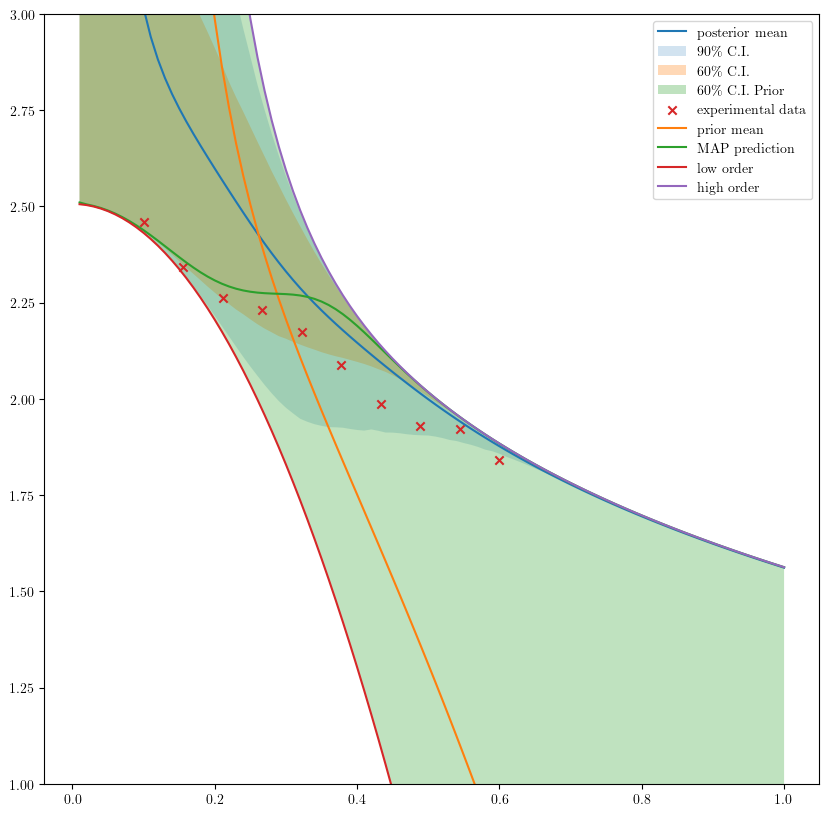

In [15]:
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(
    plot_g, 
    mean.flatten(),
    label='posterior mean'
)
ax.fill_between(
    plot_g,
    CI[0].flatten(),
    CI[3].flatten(),
    alpha=0.2,
    label=r'90\% C.I.'
)
ax.fill_between(
    plot_g,
    CI[1].flatten(),
    CI[2].flatten(),
    alpha=0.3,
    label=r'60\% C.I.'
)
ax.fill_between(
    plot_g,
    CI_prior[1].flatten(),
    CI_prior[2].flatten(),
    alpha=0.3,
    label='60\% C.I. Prior'
)
ax.scatter(
    g,
    exp_data[0],
    marker='x',
    label='experimental data'
)
ax.plot(
    plot_g, 
    mean_prior.flatten(),
    label='prior mean'
)
ax.plot(
    plot_g,
    map_prediction.flatten(),
    label='MAP prediction'
)
ax.plot(plot_g, m1_prediction[0].flatten(), label='low order')
ax.plot(plot_g, m2_prediction[0].flatten(), label='high order')
ax.set_ybound(1,3)
ax.legend()

In [24]:
weights = mix_model.evaluate_weights(
    local_variables=plot_g,
    sample=dict((key, var)
                for key, var in zip(
                    mix_model.prior.keys(),
                    mix_model.map
                )
               )
)

_, CI_weights, mean_weights, _ = mix_model.predict_weights(
    local_variables=plot_g
)

In [25]:
mean_weights.shape

(100, 2)

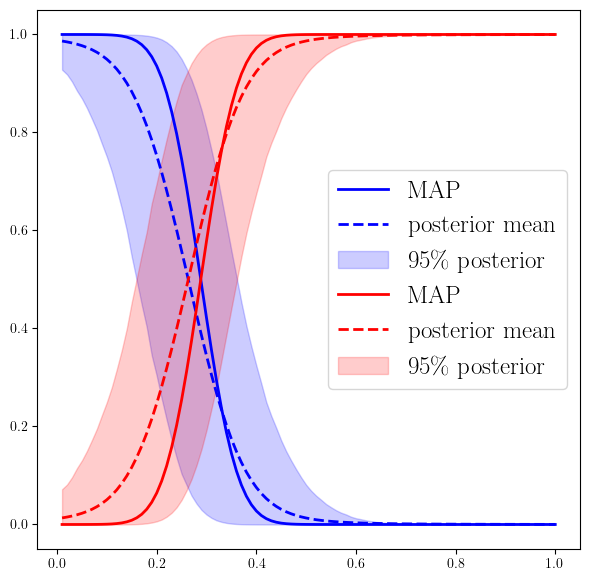

In [26]:
fig2, ax2 = plt.subplots(figsize=(7, 7))
fig2.patch.set_facecolor('white')
ax2.plot(plot_g, weights[0], color='blue', lw=2, label='MAP')
ax2.plot(plot_g, mean_weights[:, 0], color='blue', lw=2, ls='dashed', label='posterior mean')
ax2.fill_between(plot_g, CI_weights[0, :,0], CI_weights[1, :,0], color='blue', alpha=0.2, label='95\% posterior')
ax2.plot(plot_g, weights[1], color='red', lw=2, label='MAP')
ax2.plot(plot_g, mean_weights[:, 1], color='red', lw=2, ls='dashed', label='posterior mean')
ax2.fill_between(plot_g, CI_weights[0, :, 1], CI_weights[1, :, 1], color='red', alpha=0.2, label='95\% posterior')
ax2.legend(fontsize=18)

In [19]:
low_y = m1.evaluate(plot_g)[0]
high_y = m2.evaluate(plot_g)[0]

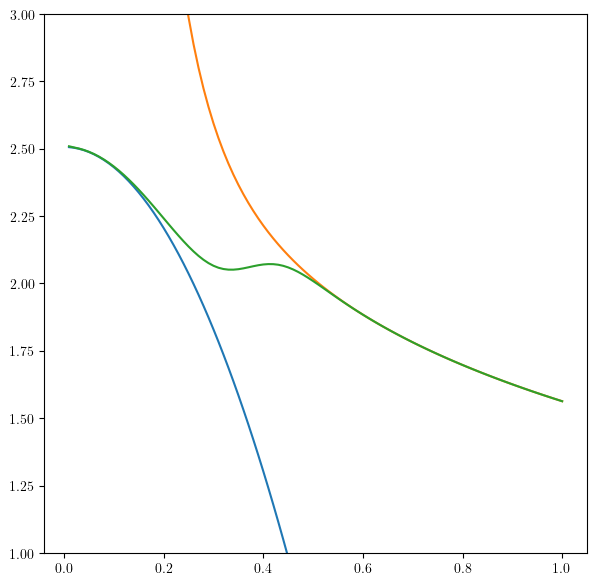

In [20]:
fig3, ax3 = plt.subplots(figsize=(7, 7))
fig3.patch.set_facecolor('white')
ax3.plot(plot_g, low_y.flatten())
ax3.plot(plot_g, high_y.flatten())
ax3.plot(
    plot_g,
    weights[0] * low_y.flatten() + weights[1] * high_y.flatten()
)
ax3.set_ybound(1,3)

In [21]:
mix_model.map

array([-17.1860499 ,   4.95722521])

## Testing some things

In [22]:
from scipy.stats import norm

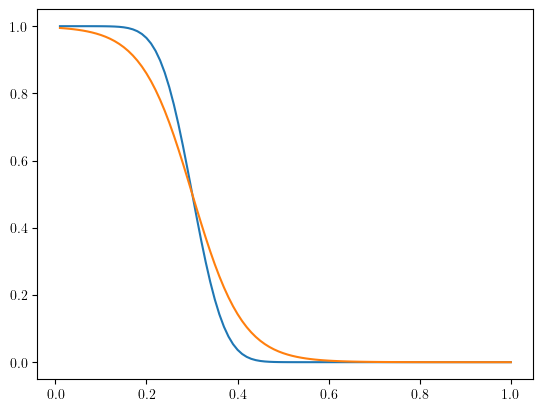

In [23]:
plt.plot(plot_g, norm.cdf(-17.997 * plot_g + 5.409))
plt.plot(plot_g, np.exp(-17.997 * plot_g + 5.409) / (1 + np.exp(-17.997 * plot_g + 5.409)))